<a href="https://colab.research.google.com/github/christopher3996/Predicting-claps-of-MEDIUM-articles-2020/blob/master/ML_clap_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting claps of MEDIUM articles 2020**
## *Advanced Data Analytics for Management Support*
### *Christopher Gerling - Humboldt University of Berlin*

This notebook provides a modern approach for predicting the number of claps a MEDIUM article is going to reach after publication. The model uses both methods of NLP (including Word2Vec embeddings) and general feedforward neural networks. As a main package for machine learning, the *sklearn* tools will be applied to model a ML regession.

# 1. Data Loading

In [ ]:
# connect to Google Drive
from google.colab import drive
drive.mount("/content/gdrive")

In [ ]:
# import libraries
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import PowerTransformer
import pickle
import warnings
from IPython.display import Image

# settings
warnings.filterwarnings("ignore")
%matplotlib inline


## 1.1. Read CSV files as Data Frames


In [ ]:
# training data
df_train = pd.read_csv("gdrive/My Drive/Adams Assignment/Train.csv", sep=",") 

# testing data
df_test = pd.read_csv("gdrive/My Drive/Adams Assignment/Test.csv", sep=",")    

In [ ]:
# check train data frame
df_train.head()

,audioVersionDurationSec,codeBlock,codeBlockCount,collectionId,createdDate,createdDatetime,firstPublishedDate,firstPublishedDatetime,imageCount,isSubscriptionLocked,language,latestPublishedDate,latestPublishedDatetime,linksCount,postId,readingTime,recommends,responsesCreatedCount,socialRecommendsCount,subTitle,tagsCount,text,title,totalClapCount,uniqueSlug,updatedDate,updatedDatetime,url,vote,wordCount,publicationdescription,publicationdomain,publicationfacebookPageName,publicationfollowerCount,publicationname,publicationpublicEmail,publicationslug,publicationtags,publicationtwitterUsername,tag_name,slug,name,postCount,author,bio,userId,userName,usersFollowedByCount,usersFollowedCount,scrappedDate
0,0,NaN,0.0,638f418c8464,2018-09-18,2018-09-18 20:55:34,2018-09-18,2018-09-18 20:57:03,1,False,en,2018-09-18,2018-09-18 20:58:20,1,10007d3018fe,0.958491,2,0,0,A major private IT company implements blockcha...,5,"Private Business, Government and Blockchain\n\...","Private Business, Government and Blockchain",100,private-business-government-and-blockchain-100...,2018-09-18,2018-09-18 20:58:20,https://medium.com/s/story/private-business-go...,False,201,ICOBox is the first and the biggest new genera...,NaN,icobox.io,NaN,ICOBox,support@icobox.io,icobox-io,"BLOCKCHAIN,ICO,ETHEREUM,ETHEREUM BLOCKCHAIN,TO...",icobox_io,Blockchain,blockchain,Blockchain,265164.0,Anar Babaev,NaN,f1ad85af0169,babaevanar,450.0,404.0,20181104
1,0,NaN,0.0,638f418c8464,2018-09-18,2018-09-18 20:55:34,2018-09-18,2018-09-18 20:57:03,1,False,en,2018-09-18,2018-09-18 20:58:20,1,10007d3018fe,0.958491,2,0,0,A major private IT company implements blockcha...,5,"Private Business, Government and Blockchain\n\...","Private Business, Government and Blockchain",100,private-business-government-and-blockchain-100...,2018-09-18,2018-09-18 20:58:20,https://medium.com/s/story/private-business-go...,False,201,ICOBox is the first and the biggest new genera...,NaN,icobox.io,NaN,ICOBox,support@icobox.io,icobox-io,"BLOCKCHAIN,ICO,ETHEREUM,ETHEREUM BLOCKCHAIN,TO...",icobox_io,Samsung,samsung,Samsung,5708.0,Anar Babaev,NaN,f1ad85af0169,babaevanar,450.0,404.0,20181104
2,0,NaN,0.0,638f418c8464,2018-09-18,2018-09-18 20:55:34,2018-09-18,2018-09-18 20:57:03,1,False,en,2018-09-18,2018-09-18 20:58:20,1,10007d3018fe,0.958491,2,0,0,A major private IT company implements blockcha...,5,"Private Business, Government and Blockchain\n\...","Private Business, Government and Blockchain",100,private-business-government-and-blockchain-100...,2018-09-18,2018-09-18 20:58:20,https://medium.com/s/story/private-business-go...,False,201,ICOBox is the first and the biggest new genera...,NaN,icobox.io,NaN,ICOBox,support@icobox.io,icobox-io,"BLOCKCHAIN,ICO,ETHEREUM,ETHEREUM BLOCKCHAIN,TO...",icobox_io,It,it,It,3720.0,Anar Babaev,NaN,f1ad85af0169,babaevanar,450.0,404.0,20181104
3,0,NaN,0.0,NaN,2018-01-07,2018-01-07 17:04:37,2018-01-07,2018-01-07 17:06:29,13,False,en,2018-01-07,2018-01-07 17:18:38,24,1000c43bcb97,19.716981,0,0,0,Introduction,5,EPQ draft 1 (4844 words)\nhttps://upload.wikim...,EPQ draft 1 (4844 words),0,introduction-3-1000c43bcb97,2018-01-07,2018-01-07 17:18:39,https://medium.com/s/story/introduction-3-1000...,False,4854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Technology,technology,Technology,166125.0,George Sykes,NaN,93b9e94f08ca,tasty231,6.0,22.0,20181104
4,0,NaN,0.0,NaN,2018-01-07,2018-01-07 17:04:37,2018-01-07,2018-01-07 17:06:29,13,False,en,2018-01-07,2018-01-07 17:18:38,24,1000c43bcb97,19.716981,0,0,0,Introduction,5,EPQ draft 1 (4844 words)\nhttps://upload.wikim...,EPQ draft 1 (4844 words),0,introduction-3-1000c43bcb97,2018-01-07,2018-01-07 17:18:39,https://medium.com/s/story/introduction-3-1000...,False,4854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Robotics,robotics,Robotics,9103.0,George Sykes,NaN,93b9e94f08ca,tasty231,6.0,22.0,20181104


In [ ]:
# check test data frame
df_test.head()

,Unnamed: 0,index,Author,PublicationDetails,Responses,Header,Text,Length
0,0,0,Daniel Jeffries,"Daniel Jeffries in HackerNoon.comJul 31, 2017",627 responses,Why Everyone Missed the Most Mind-Blowing Feat...,There’s one incredible feature of cryptocurren...,23401
1,1,1,Noam Levenson,"Noam Levenson in HackerNoon.comDec 6, 2017",156 responses,NEO versus Ethereum: Why NEO might be 2018’s s...,"<img class=""progressiveMedia-noscript js-progr...",23972
2,2,2,Daniel Jeffries,"Daniel Jeffries in HackerNoon.comJul 21, 2017",176 responses,The Cryptocurrency Trading Bible,So you want to trade cryptocurrency?You’ve see...,402
3,3,5,Haseeb Qureshi,"Haseeb Qureshi in HackerNoon.comFeb 19, 2018",72 responses,Stablecoins: designing a price-stable cryptocu...,A useful currency should be a medium of exchan...,19730
4,4,7,William Belk,"William Belk in HackerNoon.comJan 28, 2018",19 responses,Chaos vs. Order — The Cryptocurrency Dilemma,Crypto crypto crypto crypto. It’s here. It’s h...,5324


# 2. Feature Selection

# 2.1. Check for intersecting column names

By taking a look at the feature names i.e. column names, it becomes obvious that the feature names of the training dataframe compared to those of the testing dataframe are not equal and hence a transformation needs to be applied.

In [ ]:
# check for intersecting feature names
test_colnames = df_test.columns.values
print(test_colnames)
train_colnames = df_train.columns.values
print(train_colnames)
if np.intersect1d(train_colnames,test_colnames).size == 0:
  print("\nThere are no intersecting column names.")

['Unnamed: 0' 'index' 'Author' 'PublicationDetails' 'Responses' 'Header'
 'Text' 'Length']
['audioVersionDurationSec' 'codeBlock' 'codeBlockCount' 'collectionId'
 'createdDate' 'createdDatetime' 'firstPublishedDate'
 'firstPublishedDatetime' 'imageCount' 'isSubscriptionLocked' 'language'
 'latestPublishedDate' 'latestPublishedDatetime' 'linksCount' 'postId'
 'readingTime' 'recommends' 'responsesCreatedCount'
 'socialRecommendsCount' 'subTitle' 'tagsCount' 'text' 'title'
 'totalClapCount' 'uniqueSlug' 'updatedDate' 'updatedDatetime' 'url'
 'vote' 'wordCount' 'publicationdescription' 'publicationdomain'
 'publicationfacebookPageName' 'publicationfollowerCount'
 'publicationname' 'publicationpublicEmail' 'publicationslug'
 'publicationtags' 'publicationtwitterUsername' 'tag_name' 'slug' 'name'
 'postCount' 'author' 'bio' 'userId' 'userName' 'usersFollowedByCount'
 'usersFollowedCount' 'scrappedDate']

There are no intersecting column names.


## 2.2. Final Features
The training data set differs in its structure from the test data set. Since the final predictions will be based on the features of the test data, the superfluous features of training data set need to be harmonized. The **Index** is needed for a later mapping of the final predictions in the output file. The **Claps** are the target variable of the presented model. With **DaysPublication** the publication duration in days is measured. A column **Text** contains the title and the textual content of the articles and will be used for NLP modelling. The count of followers is given by **AuthorFollowers**. The features **TitleWordCount** and **TextWordCount** represent the length of the title and the article.
Some of these features will be created and/or transformed in the following section for a neural network data preparation.





Training Data | Test Data | New Column Name
--- | --- | ---
N/A | 'Unnamed: 0' | [drop]
N/A | 'index' | '**Index'**
'totalClapCount' | N/A | **'Claps'**
'author' | 'Author' | [drop]
'firstPublishedDate' | 'PublicationDetails' | **'DaysPublication'**
N/A | 'Responses' | [drop]
'title' | 'Header' | [drop]
'text' | 'Text' | **'Text'**
'wordCount'  | 'Length' | [drop]
various | N/A  | [drop]
'usersFollowedByCount'  | N/A | **'AuthorFollowers'**
N/A  | N/A | **'TitleWordCount'**
N/A  | N/A | **'TextWordCount'**



## 2.3. Feature Extraction

### 2.3.1. Feature Extraction: *DaysPublication*

In [ ]:
# test data

Details = df_test.PublicationDetails
Dates =[]

def getDateOfPublication_test():
  months = ["Jan ", "Feb ", "Mar ", "Apr ", "May ", "Jun ", "Jul ", "Aug ", "Sep ", "Oct ", "Nov ", "Dec "]

  for cnt, det in enumerate(Details):
    for m in months:
      if m in det:
        tmp = det[det.find(m):]
        if len(tmp)<8:
          tmp = tmp + str(", 2019")
        tmp = datetime.strptime(tmp, '%b %d, %Y')
        tmp = datetime(2019, 12, 31, 0, 0) - tmp
        Dates.append(tmp.days)

getDateOfPublication_test()
df_test["DaysPublication"]=Dates
del Dates, Details


In [ ]:
# train data

Dates = df_train.firstPublishedDate
Dates = [datetime(2018, 11, 4, 0, 0) - datetime.strptime(d, '%Y-%m-%d') for d in Dates]
Dates = [d.days for d in Dates] # scraping date 
df_train["DaysPublication"] = Dates
del Dates

The publication dates of training data and the testing data are not identically distributed. The training data was scraped on the 04th of November 2018 and the testing data about one year later. This bias will be treated in chapter 4.3. (Scaling). 

### 2.3.2. Feature Scraping: *AuthorFollowers*

From a theoretical perspective, the author of an article will influence the number of claps. The popularity of an author can be approximated by his number of followers. Since the testing dataframe does neither contain this number nor the exact username, a **composite web scraping** is used to recreate this information. 
The column *PublicationDetails* consists of the author's name and the publication date. The name is extracted and a combined Google search with the author's name and the keyword "Medium" will return the author's profile page on Medium with a high probability. This URL is then used for extracting the number of followers from the HTML.  

In [ ]:
# web scrape for author's followers

# !pip install google

from googlesearch import search 

Authors = [row[0:row.find(" in ")] for row in df_test.PublicationDetails]
Followers =[]

def getAuthorFollowers():
  months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

  for cnt, auth in enumerate(Authors):

    for m in months:
      if m in auth:
        Authors[cnt] = auth[0:auth.find(m)]

    # has this author been scraped? (speed up)
    flag = False
    for cnt2 in range(0, cnt):
      if auth == Authors[cnt2]:
        Followers.append(Followers[cnt2])
        flag = True
        break

    if flag:
      print(Authors[cnt], Followers[cnt])
      continue

    # Google search
    import requests
    for g_res in search("Medium " + Authors[cnt], tld='com', lang='en', num=10, start=0, stop=10, pause=2.0):
      if "https://medium.com/@" in g_res:
        page = requests.get(g_res)

        index = page.text.find("Followers")-9
        if index<0:
          continue
        tmp =page.text[index-10:index]
        tmp = tmp[tmp.find(">")+1:]
        tmp = tmp.replace("K","000")
        tmp = tmp.replace(".","")
        tmp = tmp.replace(",","")
        tmp = int(tmp)
        Followers.append(tmp)
        print(Authors[cnt], tmp)
        break
    else:
      Followers.append(0)

# apply on test data
getAuthorFollowers()
df_test["AuthorFollowers"]=Followers    
del Authors, Followers

# train data
df_train.rename(columns={"usersFollowedByCount":"AuthorFollowers"}, inplace=True)

Daniel Jeffries 53000
Noam Levenson 117000
Daniel Jeffries 53000
Haseeb Qureshi 193000
William Belk 39000
Daniel Jeffries 53000
Coinbase 63000
David Gilbertson 30000
Daniel Jeffries 53000
Indrek Lasn 23000
Jimmy Odom 15000
Chris Douthit 281
Daniel van Flymen 111000
Mohit Mamoria 116000
Adrian Gallagher 244
Tiffany Hayden 52000
Michelle Leech 49
Taylor Pearson 101000
Flavio Lamenza 2000
Taylor Pearson 101000
Mohit Mamoria 116000
Zebpay 64000
Blake Urban 354
Alvaro Videla 55000
Chris Newman 55000
Alvaro Videla 55000
Gid M-K; Health Nerd 154000
Alvaro Videla 55000
Nafeez Ahmed 28000
J. Kenji López-Alt 21000
Corinne Kocher 795
Michael Pollan 51000
Brooke Siem 197000
Kris Gage 84000
The Aspen Institute 198000
Elaheh Nozari 114
Shannon Ashley 30000
Hannah White 14000
Gid M-K; Health Nerd 154000
Kim Screen 24000
Kris Gage 84000
VeChain Foundation 105000
TE-FOOD 31000
Shaun Chavis 216
Nick Jeffries 273
Micki Seibel 13000
Nafeez Ahmed 28000
Vincent Bevins 33000
TE-FOOD 31000
Shannon Ashley 3000

### 2.3.3. Feature Extraction: *TitleWordCount*

In [ ]:
def countHeaderWords(input_header):
  tmp = input_header.split(" ")
  return len(tmp)

# test data
cntHeader = [countHeaderWords(str(h)) for h in df_test.Header]
df_test["HeaderWordCount"] = cntHeader

# train data
cntHeader = [countHeaderWords(str(h)) for h in df_train.title]
df_train["HeaderWordCount"] = cntHeader
del cntHeader

### 2.3.4. Feature Extraction: *TextWordCount*
The feature extraction of **TextWordCount** will be performed after the NLP preprocessing in chapter 4.5.

## 2.4. Feature Reduction

Two new dataframes **df_train_new** and **df_test_new** are created with the defined features for the prediciton model.

In [ ]:
# Create Reduced Test DataFrame
df_test_new = df_test.loc[:,["index", "Header", "Text", "DaysPublication", "AuthorFollowers","HeaderWordCount"]].values
df_test_new = pd.DataFrame(df_test_new)
df_test_new.columns = ["Index","Header", "Text", "DaysPublication", "AuthorFollowers","TitleWordCount"]
df_test_new["Header"].fillna(" ", inplace = True)   # replace missing headlines
df_test_new["Text"] = df_test_new["Header"] + " " + df_test_new["Text"]
del df_test_new["Header"] 
df_test_new.head()

,Index,Text,DaysPublication,AuthorFollowers,TitleWordCount
0,0,Why Everyone Missed the Most Mind-Blowing Feat...,883,53000,9
1,1,NEO versus Ethereum: Why NEO might be 2018’s s...,755,117000,10
2,2,The Cryptocurrency Trading Bible So you want t...,893,53000,3
3,5,Stablecoins: designing a price-stable cryptocu...,680,193000,5
4,7,Chaos vs. Order — The Cryptocurrency Dilemma C...,702,39000,5


In [ ]:
# Create Reduced Train DataFrame
df_train_new = df_train.loc[:,["totalClapCount", "title", "text", "DaysPublication", "AuthorFollowers","HeaderWordCount"]].values
df_train_new = pd.DataFrame(df_train_new)
df_train_new.columns = ["Claps", "Header", "Text", "DaysPublication", "AuthorFollowers","TitleWordCount"]
df_train_new.Text[3]
df_train_new["Text"] = df_train_new["Header"] + " " + df_train_new["Text"]
del df_train_new["Header"] 
df_train_new.head()


,Claps,Text,DaysPublication,AuthorFollowers,TitleWordCount
0,100,"Private Business, Government and Blockchain Pr...",47,450,5
1,100,"Private Business, Government and Blockchain Pr...",47,450,5
2,100,"Private Business, Government and Blockchain Pr...",47,450,5
3,0,EPQ draft 1 (4844 words) EPQ draft 1 (4844 wor...,301,6,5
4,0,EPQ draft 1 (4844 words) EPQ draft 1 (4844 wor...,301,6,5


# 3. Data Cleaning

## 3.1. Structure

In [ ]:
#print("The Training Data has" + len(df_train.index) + " rows and " + len(df_train.columns) + " columns.")
print("The Training Data has %d rows and %d columns." %  (len(df_train_new.index), len(df_train_new.columns)))
print("The Testing Data has %d rows and %d columns." %  (len(df_test_new.index), len(df_test_new.columns)))
#df_train.shape

The Training Data has 279577 rows and 5 columns.
The Testing Data has 514 rows and 5 columns.


## 3.2. Remove Dublicate Values

There are some dublicate rows in **df_train_new** due to the exclusion of the feature *tag*. In this new dataframe, the dublicate rows have no purpose anymore and can be dropped. 

In [ ]:
# remove dublicates in the train set
len_before = len(df_train_new.Claps)
df_train_new = df_train_new.drop_duplicates()
len_after = len(df_train_new.Claps)
print(str(len_before - len_after) + " (" + format(100*(len_before - len_after)/len_before, '.2f') + "%) dublicate rows have been deleted.")
del len_before, len_after

207322 (74.16%) dublicate rows have been deleted.


## 3.3. Remove Missing Values

In [ ]:
# drop null values
n = df_train_new.isnull().sum()
df_train_new = df_train_new.dropna()
print(str(n.sum()) + " row(s) dropped.")

1 row(s) dropped.


# 4. Feature Transformation/Scaling 

## 4.1. NLP Preprocessing: *Text*

A literature-based approach of NLP preprocessing is performed by using regular expressions with **re** and the NLP library **nltk**. In this process, the HTML tags, links and non-alphabetic characters are deleted first. Then the lower-case text is tokenized into single words and all the english stopwords are removed. Finally a simple lemmatization operation is applied on the words. The output is a list (bag) of words for each article, stored in the column **Text**. 

In [ ]:
import re
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

def nlp_preprocessing(input_data):

  #remove HTML tags, Links and non-aphabetic characters
  tmp = re.sub(r"<[^>]*>", "", input_data, flags=re.MULTILINE)
  tmp = re.sub(r"http\S+", "", tmp, flags=re.MULTILINE)
  tmp = re.sub(r"[^a-zA-Z]", " ", tmp, flags=re.MULTILINE)

  # to lower case
  tmp = tmp.lower()

  # tokenization
  tokenizer = RegexpTokenizer(r'\w+')
  tmp = tokenizer.tokenize(tmp)

  # remove stopwords
  stop_words = stopwords.words("english")
  tmp = [word for word in tmp if word not in stop_words]

  # lemmatization
  # only include words, exclude single characters
  lemmatizer = WordNetLemmatizer()
  tmp = [lemmatizer.lemmatize(word, pos='v') for word in tmp if len(word)>1]

  return tmp

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# apply cleaning on training data
train_text = pd.DataFrame(df_train_new)  
tqdm.pandas()
df_train_new["Text"] = train_text["Text"].progress_apply(lambda x: nlp_preprocessing(x))
del train_text


In [ ]:
# apply cleaning on testing data
test_text = pd.DataFrame(df_test_new)  
tqdm.pandas()
df_test_new["Text"] = test_text["Text"].progress_apply(lambda x: nlp_preprocessing(x))
del test_text


## 4.2. Scaling: *Claps*

In order to reduce the effect of outliers on the efficiency of the neural network(s), I define the *95-percentile* as an upper bound for the claps. Any number above will be truncated to this **upper_bound**. Afterwards, the claps are scaled by a self-defined **Min-Max-Log-Scaler**.

### 4.2.1. Outlier Treatment: *Claps*

In [ ]:
# getting a first intention of Claps 
print("The min(Claps) is " + str(df_train_new.Claps.min()) + " and the max(Claps) is " + str(df_train_new.Claps.max()) + ".")

The min(Claps) is 0 and the max(Claps) is 291706.


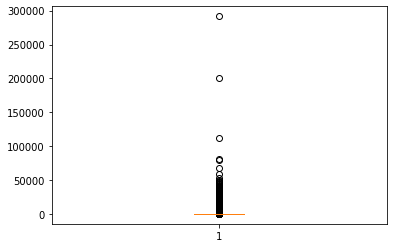

In [ ]:
_=plt.boxplot(df_train_new.Claps)

The boxplot visualisation shows that there exist articles with a very high amount of claps. A maximum of 291706 claps has been reached by one article. In order to smooth the distribution, these outliers are truncated to the 95-percentile:

In [ ]:
# calculate the percentiles
np.percentile(df_train_new.Claps,[0,25,50,75,90,95,99,100])

array([0.0, 0.0, 5.0, 62.0, 230.0, 509.0, 2314.470000000001, 291706.0],
      dtype=object)

In [ ]:
# outlier treatment

# select upper bound (95-percentile)
upper_bound = int(np.percentile(df_train_new.Claps,[95]))

# truncate by setting 
df_train_new.Claps[df_train_new.Claps > upper_bound] = upper_bound

### 4.2.2. Scaling: *Claps*
For better results in a neural network, the target variable will be scaled by using a self-defined Min-Max-Log-Scalar, reshaping the distribution and setting the minimum to 0 and the maximum to 1.

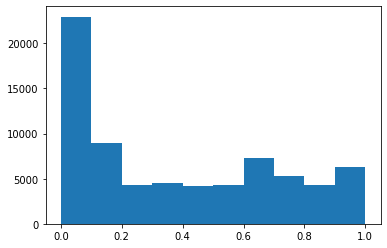

In [ ]:
# clap transformation
def logTransformation(c):
  # log transformation 
  c = np.log(c+1)
  return c

def min_maxTransformation(c, max):
  c = c / max 
  return c

# apply on train data
trans_Claps = [logTransformation(c) for c in df_train_new.Claps] 
upper_bound_log = max(trans_Claps)
trans_Claps = [min_maxTransformation(c, upper_bound_log) for c in trans_Claps]
plt.hist(trans_Claps)
df_train_new["Claps"] = trans_Claps
del trans_Claps



In [ ]:
# retransformation function (needed later)
def re_Transformation_Claps(c):
  if c<0:
    c=0
  c = c * upper_bound_log
  c = np.exp(c)
  c = c-1
  return c

## 4.3. Scaling: *DaysPublication*

The sklearn.preprocessing package offers a class **PowerTransformer**, that performs a Box-Cox transformation of strictly positive numeric data <center>$d_{1..n} \in \mathbb{R}^{+}$.</center>

The advantage of Box-Cox transformation is a normal-like distribution with a mean set to 0:

<center>$d_{1..n} \sim N(0,1) $. </center>

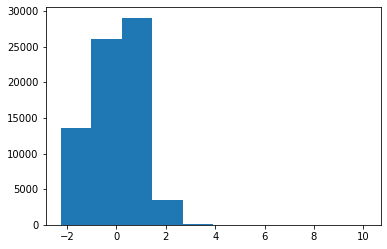

In [ ]:
# train data

from sklearn.preprocessing import PowerTransformer

tmp_min = min(df_train_new.DaysPublication)

tmp = [(dp - tmp_min + 1) for dp in df_train_new.DaysPublication]
del tmp_min
tmp = np.array(tmp)
tmp = tmp.reshape(-1, 1)

scaler_DaysPublication = PowerTransformer(method='box-cox', standardize=True, copy=True)
scaler_DaysPublication.fit(tmp)
df_train_new.DaysPublication = scaler_DaysPublication.transform(tmp)
_=plt.hist(df_train_new.DaysPublication)


As mentioned in a previous chapter, the application of this scaler on the testing data gives biased results. One reason for this are different dates of scraping and different distributions of publication dates. Furthermore, it is not completely clear, when the testing data has been scraped. For that reason, I decided to harmonize this temporal gap by setting the latest date of publication for both data sets to $t_0$.

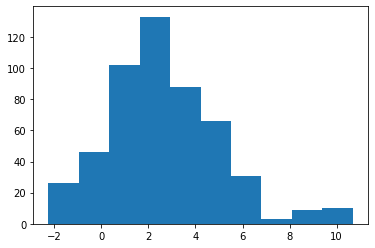

In [ ]:
# test data

tmp_min = min(df_test_new.DaysPublication)

tmp = [(dp - tmp_min + 1) for dp in df_test_new.DaysPublication]
del tmp_min
tmp = np.array(tmp)
tmp = tmp.reshape(-1, 1)

df_test_new.DaysPublication =scaler_DaysPublication.transform(tmp)
_=plt.hist(df_test_new.DaysPublication)


The testing data still shows a bias after the transformation.

## 4.4. Scaling: *AuthorFollowers*

For scaling the author's followers a Box-Cox transformation by using PowerTransformer is applied, as well.

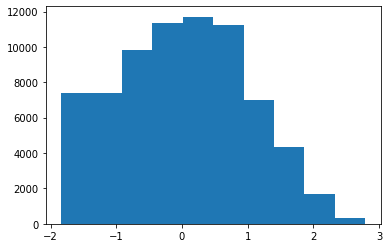

In [ ]:
# train data

from sklearn.preprocessing import PowerTransformer

tmp = [(dp+1) for dp in df_train_new.AuthorFollowers]
tmp = np.array(tmp)
tmp = tmp.reshape(-1, 1)

scaler_AuthorFollowers = PowerTransformer(method='box-cox', standardize=True, copy=True)
scaler_AuthorFollowers.fit(tmp)
df_train_new.AuthorFollowers = scaler_AuthorFollowers.transform(tmp)
_=plt.hist(df_train_new.AuthorFollowers)

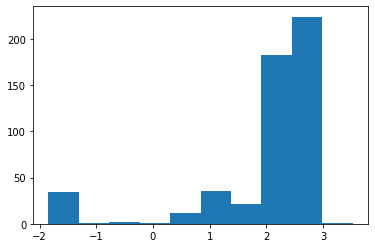

In [ ]:
# test data

tmp = [(dp + 1) for dp in df_test_new.AuthorFollowers]
tmp = np.array(tmp)
tmp = tmp.reshape(-1, 1)

df_test_new.AuthorFollowers = scaler_AuthorFollowers.transform(tmp)
_=plt.hist(df_test_new.AuthorFollowers)

The distribution of the testing data after applying the scaling is left-skewed and does not follow a normal distribution.

## 4.4. Scaling: *TitleWordCount*

Again, the Box-Cox transformation is applied.

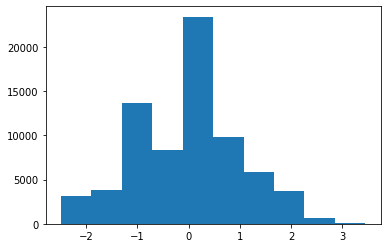

In [ ]:
# train data

from sklearn.preprocessing import PowerTransformer

tmp = [(dp+1) for dp in df_train_new.TitleWordCount]
tmp = np.array(tmp)
tmp = tmp.reshape(-1, 1)

scaler_TitleWordCount = PowerTransformer(method='box-cox', standardize=True, copy=True)
scaler_TitleWordCount.fit(tmp)
df_train_new.TitleWordCount = scaler_TitleWordCount.transform(tmp)
_=plt.hist(df_train_new.TitleWordCount)

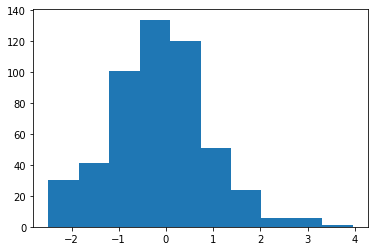

In [ ]:
# test data

tmp = [(dp + 1) for dp in df_test_new.TitleWordCount]
tmp = np.array(tmp)
tmp = tmp.reshape(-1, 1)

df_test_new.TitleWordCount = scaler_TitleWordCount.transform(tmp)
_=plt.hist(df_test_new.TitleWordCount)

## 4.5. Additional Feature: *TextWordCount*

The feature **TextWordCount** contains the amount of words in an article after the NLP preprocessing. This number is scaled with Box-Cox transformation.

In [ ]:
# train data
tmp = [len(BOW) for BOW in df_train_new.Text]
df_train_new["TextWordCount"] = tmp

# test data
tmp = [len(BOW) for BOW in df_test_new.Text]
df_test_new["TextWordCount"] = tmp

In [ ]:
# check df
df_train_new.head()

,Claps,Text,DaysPublication,AuthorFollowers,TitleWordCount,TextWordCount
0,0.740266,"[private, business, government, blockchain, pr...",-1.821598,0.841609,-0.748153,103
3,0.000000,"[epq, draft, word, epq, draft, word, introduct...",0.789287,-0.874553,-0.748153,2499
7,0.000000,"[ascent, data, science, sas, big, data, analys...",0.358226,-1.033736,0.979435,322
11,0.630665,"[robot, love, us, better, another, human, robo...",0.048817,0.887861,0.727353,97
16,0.534486,"[big, data, ai, iot, use, case, big, data, ai,...",1.285806,0.533171,0.187199,1060


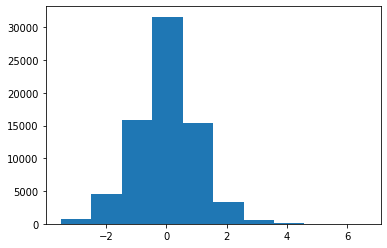

In [ ]:
# train data

from sklearn.preprocessing import PowerTransformer

tmp = [(dp+1) for dp in df_train_new.TextWordCount]
tmp = np.array(tmp)
tmp = tmp.reshape(-1, 1)

scaler_TextWordCount = PowerTransformer(method='box-cox', standardize=True, copy=True)
scaler_TextWordCount.fit(tmp)
df_train_new.TextWordCount = scaler_TextWordCount.transform(tmp)
_=plt.hist(df_train_new.TextWordCount)

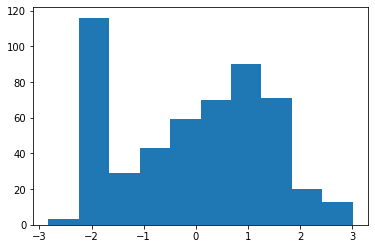

In [ ]:
# test data

tmp = [(dp + 1) for dp in df_test_new.TextWordCount]
tmp = np.array(tmp)
tmp = tmp.reshape(-1, 1)

df_test_new.TextWordCount = scaler_TextWordCount.transform(tmp)
_=plt.hist(df_test_new.TextWordCount)

## 4.6. Check Scaling 

Now, all required features have been selected and transformed in both dataframes **df_train_new** and **df_test_new**.

In [ ]:
df_train_new.head()

,Claps,Text,DaysPublication,AuthorFollowers,TitleWordCount,TextWordCount
0,0.740266,"[private, business, government, blockchain, pr...",-1.821598,0.841609,-0.748153,-1.307476
3,0.000000,"[epq, draft, word, epq, draft, word, introduct...",0.789287,-0.874553,-0.748153,2.741348
7,0.000000,"[ascent, data, science, sas, big, data, analys...",0.358226,-1.033736,0.979435,-0.232240
11,0.630665,"[robot, love, us, better, another, human, robo...",0.048817,0.887861,0.727353,-1.355499
16,0.534486,"[big, data, ai, iot, use, case, big, data, ai,...",1.285806,0.533171,0.187199,1.299583


In [ ]:
df_test_new.head()

,Index,Text,DaysPublication,AuthorFollowers,TitleWordCount,TextWordCount
0,0,"[everyone, miss, mind, blow, feature, cryptocu...",3.182518,2.327131,0.463856,2.312811
1,1,"[neo, versus, ethereum, neo, might, strongest,...",2.583197,2.533711,0.727353,2.388475
2,2,"[cryptocurrency, trade, bible, want, trade, cr...",3.227319,2.327131,-1.507654,-1.934529
3,5,"[stablecoins, design, price, stable, cryptocur...",2.205768,2.659090,-0.748153,1.977172
4,7,"[chaos, vs, order, cryptocurrency, dilemma, cr...",2.318804,2.244319,-0.748153,0.233396


## 4.7. Save Backup

In [ ]:
# save cleaned and preprocessed dataframes
with open('gdrive/My Drive/Adams Assignment/New Approach/df_train_new.pkl','wb') as path_name:
    pickle.dump(df_train_new, path_name)

with open('gdrive/My Drive/Adams Assignment/New Approach/df_test_new.pkl','wb') as path_name:
    pickle.dump(df_test_new, path_name)

with open('gdrive/My Drive/Adams Assignment/New Approach/upper_bound_log.pkl','wb') as path_name:
    pickle.dump(upper_bound_log, path_name)


In [ ]:
# load backup
import pickle
with open('gdrive/My Drive/Adams Assignment/New Approach/df_train_new.pkl','rb') as path_name:
    df_train_new = pickle.load(path_name)

with open('gdrive/My Drive/Adams Assignment/New Approach/df_test_new.pkl','rb') as path_name:
    df_test_new = pickle.load(path_name)

with open('gdrive/My Drive/Adams Assignment/New Approach/upper_bound_log.pkl','rb') as path_name:
    upper_bound_log = pickle.load(path_name)

# 5. EDA Visualization: Dependencies to Claps

## 5.1. Visualization: *Claps ~ DaysPublication*

In [ ]:
df_train_new.Claps[df_train_new.Claps>1]

Series([], Name: Claps, dtype: float64)

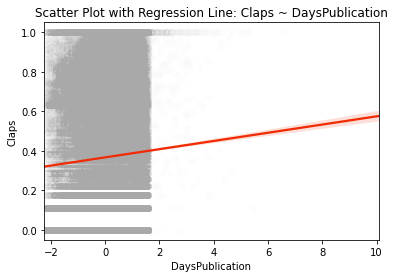

In [ ]:
import seaborn
# plt.figure(figsize=(w, h), dpi=d)
seaborn.regplot(df_train_new.DaysPublication, df_train_new.Claps,scatter=True, scatter_kws={'color': 'darkgrey','alpha':0.01},line_kws={'color':'#F12B04'})
plt.title('Scatter Plot with Regression Line: Claps ~ DaysPublication')
plt.ylabel('Claps')
plt.xlabel('DaysPublication')
plt.show()

There is a **positive trend** between DaysPublication and Claps. The assumption arises that older articles will have a higher amount of claps. 

## 5.2. Visualization: *Claps ~ AuthorFollowers*

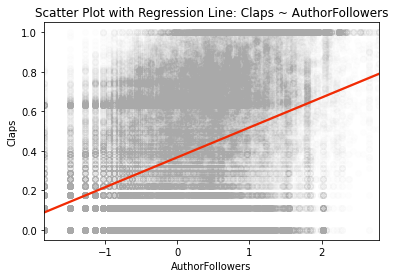

In [ ]:
import seaborn
seaborn.regplot(df_train_new.AuthorFollowers, df_train_new.Claps,scatter=True, scatter_kws={'color': 'darkgrey', 'alpha':0.01},line_kws={'color':'#F12B04'})
plt.title('Scatter Plot with Regression Line: Claps ~ AuthorFollowers')
plt.ylabel('Claps')
plt.xlabel('AuthorFollowers')
plt.show()

There is a positive trend between AuthorFollowers and Claps. It can be assumed that an author with many followers will receive more claps on his articles.

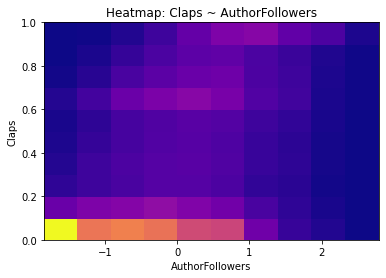

In [ ]:
plt.title('Heatmap: Claps ~ AuthorFollowers')
plt.ylabel('Claps')
plt.xlabel('AuthorFollowers')
plt.hist2d(np.array(df_train_new.AuthorFollowers), np.array(df_train_new.Claps), bins=10, normed=False, cmap='plasma')
plt.show()


The heatmap shows the composite distibution of Claps and AuthorFollowers. Authors with few followers often post articles with only few claps and the aricles with the most claps are mostly written by authors with many followers. 

## 5.3. Visualization: *Claps ~ TitleWordCount*

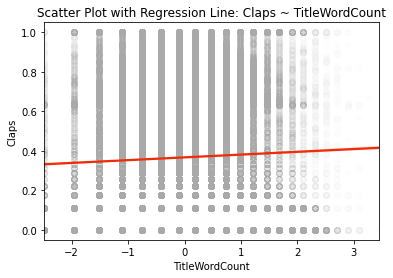

In [ ]:
seaborn.regplot(df_train_new.TitleWordCount, df_train_new.Claps,scatter=True, scatter_kws={'color': 'darkgrey', 'alpha':0.01},line_kws={'color':'#F12B04'})
plt.title('Scatter Plot with Regression Line: Claps ~ TitleWordCount')
plt.ylabel('Claps')
plt.xlabel('TitleWordCount')
plt.show()

A slight positive trend between TitleWordCount and Claps could expected.

## 5.4. Visualization: *Claps ~ TextWordCount*

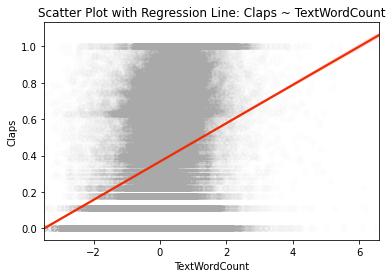

In [ ]:
seaborn.regplot(df_train_new.TextWordCount, df_train_new.Claps,scatter=True, scatter_kws={'color': 'darkgrey', 'alpha':0.01},line_kws={'color':'#F12B04'})
plt.title('Scatter Plot with Regression Line: Claps ~ TextWordCount')
plt.ylabel('Claps')
plt.xlabel('TextWordCount')
plt.show()

There is a strong positive trend between TextWordCount and Claps. It seems plausible that articles with many words have been written with lots of effort. This might explain a rising number of claps.

# 6. Training Preparation
In the later training process, a 5-fold cross validation technique will be used in order to find the best model. In the end, the final model will be tested against some additional hold-back data in a validation set. Therefore, the df_train_new is split into two data sets:

<center>$     df\rule{0.2cm}{0.15mm}train\rule{0.2cm}{0.15mm}new=:\left\{\begin{array}{ll}  df\rule{0.2cm}{0.15mm}train\rule{0.2cm}{0.15mm}fin, &80\% \\
         df\rule{0.2cm}{0.15mm}val\rule{0.2cm}{0.15mm}fin, & 20\%\end{array}\right. 
$</center>

In [ ]:
# split data
from sklearn import model_selection 
df_train_fin, df_val_fin = model_selection.train_test_split(df_train_new, test_size=0.20, random_state=42)

In [ ]:
print("Training size: " + str(len(df_train_fin)))
print("Validation size: " + str(len(df_val_fin)))

Training size: 57803
Validation size: 14451


In [ ]:
# make copy for further working
df_test_fin = df_test_new.copy()

# 7. Model Training

In the first step, a Word2Vec model with 200 dimensions is trained on the words of the training set. After checking the effectiveness of this Word2Vec model, a DocumentVector will be created as a feature that represents the whole article. 

Let $\phi(1..k)$ be called a mapping function of a regession neural network with $k$ input values and one output value, then the first MLPRegressor is trained on a feedforward neural network with

<center>$Claps \sim \phi_1(DocumentVector[1..200])$ </center>

where Claps is the regression target. Let $\psi_{1}$ be the predicted output of the first NN. 

On top of this first MLPRegressor, a second neural network is trained with

<center>$Claps \sim \phi_2(\psi_{1}, DaysPublication, AuthorFollowers, TitleWordCount, TextWordCount)$ </center>

where Claps is again the regression target and $\psi_{2}$ is the final prediction of the second model. This stacked model architecture has been chosen, in order to minimalize the regression training error $\varepsilon_{1}^{2}= (Claps - \psi_{1})^{2}$ of the first model.

## 7.1. Word2Vec Model

A Word2Vec analyzes textual data and transforms words into vectors with $k$ dimensions (word embeddings). In addition to the single words of the articles, a **bigram model** is trained for creating frequently used bigrams in the data. Here, only bigrams with a frequency of $q\geq 100$ are included.

The actual model training is done by the **gensim API** with an embedding size of $k=200$ dimensions. 

### 7.1.1. Create Bigrams

In [ ]:
import gensim
from gensim.models.phrases import Phrases

bigram_model = gensim.models.Phrases(df_train_fin.Text, min_count=100) #runs for 1-2 minutes

In [ ]:
# show all bigrams
bigram_model.vocab

In [ ]:
# apply bigram model to the training & validation data
df_train_fin.Text = [bigram_model[line] for line in df_train_fin.Text]  #runs for 3 minutes
df_val_fin.Text = [bigram_model[line] for line in df_val_fin.Text]

In [ ]:
# apply bigram model to the testing data
df_test_fin.Text = [bigram_model[line] for line in df_test_fin.Text]

In [ ]:
# check one exemplary BOW 
print(df_train_fin.Text[min(df_train_fin.index)])

['private', 'business', 'government', 'blockchain', 'private', 'business', 'government', 'blockchain', 'major', 'private', 'company', 'implement', 'blockchain', 'artificial', 'intelligence', 'internet', 'things', 'optimize', 'improve', 'high', 'technology', 'workflow', 'representatives', 'major', 'state', 'structure', 'country', 'like', 'experiment', 'much', 'decide', 'use', 'work', 'conclude', 'agreement', 'giant', 'ideal', 'example', 'interaction', 'private', 'business', 'state', 'regard', 'blockchain', 'think', 'even', 'better', 'story', 'real', 'south', 'korea', 'local', 'customs', 'office', 'sign', 'respective', 'partnership', 'agreement', 'samsung', 'believe', 'near', 'term', 'development', 'blockchain', 'build', 'examples', 'cooperation', 'world', 'best', 'technological', 'decisions', 'copy', 'supersonic', 'speed', 'one', 'cannot', 'remain', 'behind', 'trend', 'long', 'confident', 'blockchain', 'crypto', 'technologies', 'soon', 'adopt', 'around', 'world', 'st', 'century', 'would

### 7.1.2. Train W2V Model

The progress of the model training is printed out with an EpochLogger as recommended by [Kite Documentation](https://www.kite.com/python/docs/gensim.models.callbacks).

In [ ]:
# print progress

from gensim.models.callbacks import CallbackAny2Vec
class EpochLogger(CallbackAny2Vec):
  """Print progress of Word2Vec training to console"""

  def __init__(self):
    self.epoch = 0

  def on_epoch_begin(self, model):
    print("Epoch #{} start".format(self.epoch))

  def on_epoch_end(self, model):
    print("Epoch #{} end".format(self.epoch))
    self.epoch += 1

In [ ]:
# train W2V model with 200 dimensions

from gensim.models import Word2Vec    # one and a half hours of computation

epoch_logger = EpochLogger()

w2v_model = Word2Vec(df_train_fin.Text, 
                 min_count=30, 
                 window=5,    
                 iter=100,     
                 size=200, 
                 workers=4,    
                 callbacks=[epoch_logger])

# backup
with open('gdrive/My Drive/Adams Assignment/New Approach/w2v_model.pkl','wb') as path_name:
    pickle.dump(w2v_model, path_name)

In [ ]:
# load backup
with open('gdrive/My Drive/Adams Assignment/New Approach/w2v_model.pkl','rb') as path_name:
    w2v_model = pickle.load(path_name)

### 7.1.3. Check W2V Model

In [ ]:
# example vector of the word "data"
w2v_model.wv["data"]

array([ 2.7391595e-01,  3.8044600e+00, -1.7215838e+00,  2.3659195e-01,
       -2.8299406e-01, -1.1931664e+00,  3.0075574e-01, -5.7456825e-02,
       -2.0979400e+00,  3.8263050e-01,  2.2620757e+00,  6.1452430e-01,
        1.8120369e-02, -5.9481941e-02,  5.2750963e-01, -4.0597672e+00,
       -5.8676252e+00,  1.4525969e+00, -1.1779889e+00,  7.1639532e-01,
       -1.8296396e+00, -8.8170797e-01,  7.4959838e-01,  2.1699152e+00,
        1.1579524e+00,  1.5108185e+00, -1.8592255e-02,  4.8074423e-04,
       -1.2426616e+00, -1.7665329e+00,  1.5559815e+00, -3.7430823e+00,
        1.2097459e+00,  2.2563641e+00,  3.6515695e-01,  1.4929160e+00,
       -2.6334143e+00,  5.6230700e-01,  2.4246372e-02, -2.6952276e-01,
       -4.8253262e-01, -1.0279803e+00,  5.0002604e+00,  6.7241800e-01,
       -2.2582662e-01, -3.1265894e-01,  5.5842263e-01, -1.2210205e+00,
        2.4649031e+00,  1.7797656e+00,  2.0256548e+00, -9.2330211e-01,
        2.3218195e+00,  2.6495152e+00,  3.8809884e+00,  1.8341492e-01,
      

In [ ]:
# example most similar words to "python"
w2v_model.wv.most_similar("python")

[('java', 0.6856076717376709),
 ('javascript', 0.674173891544342),
 ('program_language', 0.6644961833953857),
 ('libraries', 0.6463199853897095),
 ('sql', 0.6296360492706299),
 ('scala', 0.6290716528892517),
 ('pandas', 0.6280615925788879),
 ('matlab', 0.6240498423576355),
 ('library', 0.6103489995002747),
 ('numpy', 0.6089557409286499)]

In [ ]:
# example cosine similarity of "dog" and "cat"
print(w2v_model.wv.similarity("dog", "cat"))

0.8110444


In [ ]:
# example of similar words containing one with an additional meaning that doesn't match
print(w2v_model.doesnt_match(["python", "dog", "cat", "bird"]))

python


### 7.1.4. TSNE Visualization
A popular method for visualizing a Word2Vec model is a **t-distributed stochastic neighbor embedding plot**. The algorithm is able to cluster the Word2Vec information of the high-dimensional data points. This approach reduces the number of dimensions so that it can be plotted in 2D (2 dimensions) or 3D (3 dimensions). 
In this case, I directly followed the idea and code presented by [Sergey Smetanin in 2019 in Habr](https://habr.com/en/company/mailru/blog/449984/), who uses a 2D TSNE model. Here, 10 additional most-similar words are added to the keys.


In [ ]:
# define key words and get top 10 similar words with their embeddings

keys = ['paris', 'python', 'sunday', 'twitter', 'bachelor', 'delivery', 'election', 'expensive',
        'experience', 'financial', 'food', 'ios', 'peace', 'release', 'war', 'christopher']

embedding_clusters = []
word_clusters = []
for word in keys:
  if word in w2v_model.wv.vocab:
    embeddings = []
    words = []
    for similar_word, _ in w2v_model.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(w2v_model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [ ]:
# train the TSNE model and transform the embeddings into 2D

from sklearn.manifold import TSNE
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32) 
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2) 

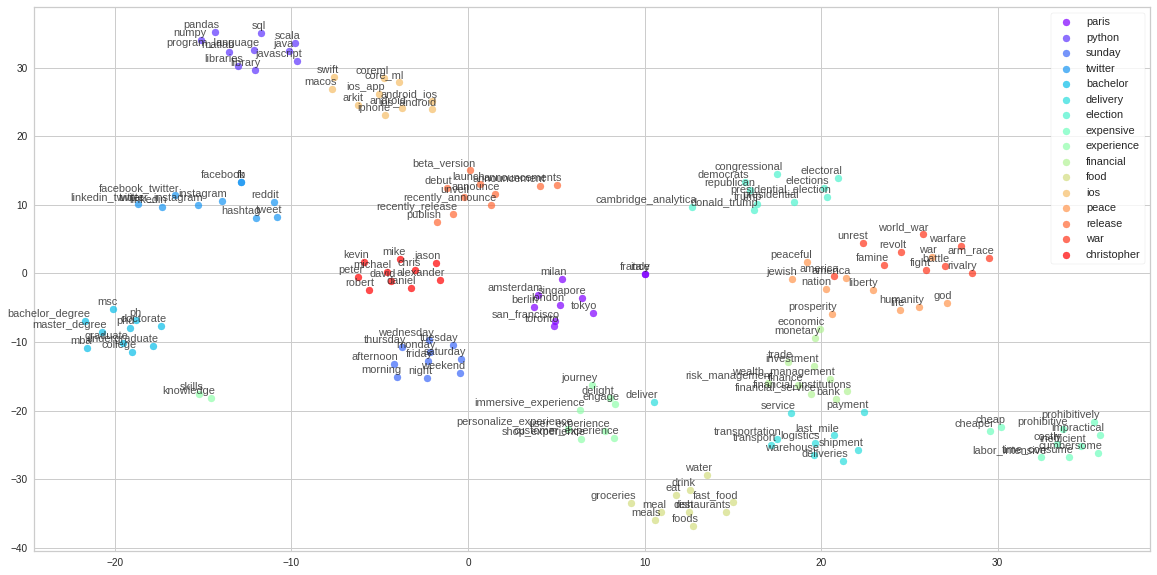

In [ ]:
# create the TSNE plot

import matplotlib.cm as cm

# surpress warning messages
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, a=0.7):
    plt.figure(figsize=(20, 10))
    colors = cm.rainbow(np.linspace(0, 1, len(labels))) 
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:,0]
        y = embeddings[:,1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.8, xy=(x[i], y[i]), xytext=(5, 2), 
                         textcoords='offset points', ha='right', va='bottom', size=11)
    plt.legend(loc='upper right', frameon=True, fontsize=11)
    plt.grid(True)
    plt.show()


tsne_plot_similar_words(keys, embeddings_en_2d, word_clusters)

The TSNE plot shows the predefined key word as a cluster centroid and adds the top 10 most similar words of the Word2Vec model to the plot. The clustered words appear to be sensibly chosen. For instance, the cluster key "paris" shows other metropolitan cities around the world and this cluster can be easily distiguished from others in the plot.  

### 7.1.5. Apply W2V Model

The final step in the Word2Vec model is the calculation of a document vector that represents a specific article with just one single vector of dimansionality $k=200$. There are different approaches to create such a document vector. The problem arises that the articles have a different number of words. 

In this solution the **arithmetic mean** is used as a way to consolidate the different vectors into one. It can be assumed, that a vector space with $k=200$ dimensions is sufficiently large to create enough distinction/distance between the documents. Now, similar articles will obtain a similar vector projection. 

For instance, an article about *data science* should me more similar to an article about *maths* than to a *political* text.

In [ ]:
# calculate document vector

def calcDocMean(input_data):
  tmp = [w2v_model.wv[word] for word in input_data if word in list(w2v_model.wv.vocab)] 
  tmp = np.array(tmp)

  if len(tmp)<1:
    return np.zeros((200,), dtype=float) 
  else: return np.nanmean(tmp.astype('float64'), axis=0)

In [ ]:
df_train_fin.head()

,Claps,Text,DaysPublication,AuthorFollowers,TitleWordCount,TextWordCount
256583,1.000000,"[catch, near, future, commercial, ai, catch, n...",1.388788,0.440865,-0.104861,1.696101
62151,0.509760,"[take, leap, data, science, take, leap, data, ...",1.477952,-0.626452,-0.415290,-0.907792
270177,0.826588,"[compare, different, methods, achieve, sparse,...",-1.183215,1.412331,2.109287,0.804154
39471,0.000000,"[compliance, collaboration, key, data, project...",0.258091,2.021836,0.727353,-0.337829
39747,0.630665,"[ai, accessibility, improve, user, access, ess...",0.147001,-0.665939,0.979435,0.403703


In [ ]:
# train data

from tqdm import tqdm
tqdm.pandas()
tmp_train_doc = df_train_fin.Text.progress_apply(lambda x: calcDocMean(x))
tmp_train_doc = [list(r) for r in tmp_train_doc]
df_train_fin["DocumentVector"] = tmp_train_doc
del tmp_train_doc

# backup
with open('gdrive/My Drive/Adams Assignment/New Approach/df_train_fin.pkl','wb') as path_name:
    pickle.dump(df_train_fin, path_name)

In [ ]:
# validation data

from tqdm import tqdm
tqdm.pandas()
tmp_val_doc = df_val_fin.Text.progress_apply(lambda x: calcDocMean(x))
tmp_val_doc = [list(r) for r in tmp_val_doc]
df_val_fin["DocumentVector"] = tmp_val_doc
del tmp_val_doc

# backup
with open('gdrive/My Drive/Adams Assignment/New Approach/df_val_fin.pkl','wb') as path_name:
    pickle.dump(df_val_fin, path_name)

In [ ]:
# test data

from tqdm import tqdm
tqdm.pandas()
tmp_test_doc = df_test_fin.Text.progress_apply(lambda x: calcDocMean(x))
tmp_test_doc = [list(r) for r in tmp_test_doc]
df_test_fin["DocumentVector"] = tmp_test_doc
del tmp_test_doc

# backup
with open('gdrive/My Drive/Adams Assignment/New Approach/df_test_fin.pkl','wb') as path_name:
    pickle.dump(df_test_fin, path_name)

### 7.1.6. Load Backup

In [ ]:
import pickle

with open('gdrive/My Drive/Adams Assignment/New Approach/df_test_fin.pkl','rb') as path_name:
    df_test_fin = pickle.load(path_name)

with open('gdrive/My Drive/Adams Assignment/New Approach/df_val_fin.pkl','rb') as path_name:
    df_val_fin = pickle.load(path_name)

with open('gdrive/My Drive/Adams Assignment/New Approach/df_train_fin.pkl','rb') as path_name:
    df_train_fin = pickle.load(path_name)

### 7.1.7. Check the Document Vectors

In order to check the semantics of the document vectors, four keyword-tuples containing words from one specific topic are chosen:


*   Blockchain & Bitcoin
*   AI & ML
*   Trump & Obama
*   Company & Business


For each tuple, 10 articles containing both words are sampled and a composite document vector for those 10 articles is calculated. Then a inverse search for the words with the highest probability is applied. This way, one can quickly evaluate whether the document vector approach is effective. 

In [ ]:
# choose 10 blockchain/bitcoin articles
blockchain_articles = [a  for a in df_train_fin.Text if "blockchain" in a and "bitcoin" in a]
blockchain_articles= blockchain_articles[0:10]
bc = [calcDocMean(b) for b in blockchain_articles]

# print words with highest similarity to this composite vector
bc_docVec_mean = np.mean(bc, axis=0)
print(w2v_model.wv.most_similar([bc_docVec_mean]))

del bc, blockchain_articles, bc_docVec_mean

[('blockchain', 0.47601714730262756), ('cryptocurrency', 0.4614923596382141), ('crypto', 0.4357680380344391), ('platform', 0.42325544357299805), ('decentralize', 0.42101091146469116), ('company', 0.4187498986721039), ('blockchain_technology', 0.41389739513397217), ('marketplace', 0.41275453567504883), ('already', 0.41003623604774475), ('also', 0.4092147946357727)]


In [ ]:
# choose 10 ai/ml articles
ai_articles = [a  for a in df_train_fin.Text if "ai" in a and "ml" in a]
ai_articles= ai_articles[0:10]
ai = [calcDocMean(a) for a in ai_articles]

# print words with highest similarity to this composite vector
ai_docVec_mean = np.mean(ai, axis=0)
print(w2v_model.wv.most_similar([ai_docVec_mean]))

del ai, ai_articles, ai_docVec_mean

[('ai', 0.5246028900146484), ('machine_learn', 0.456862211227417), ('artificial_intelligence', 0.4529162049293518), ('need', 0.43408918380737305), ('technology', 0.42836087942123413), ('solve_problems', 0.4178697168827057), ('today', 0.41686302423477173), ('work', 0.41660672426223755), ('able', 0.4127207398414612), ('think', 0.41087085008621216)]


In [ ]:
# choose 10 trump/obama articles
america_articles = [a  for a in df_train_fin.Text if "trump" in a and "obama" in a]
america_articles= america_articles[0:10]
am = [calcDocMean(a) for a in america_articles]

# print words with highest similarity to this composite vector
am_docVec_mean = np.mean(am, axis=0)
print(w2v_model.wv.most_similar([am_docVec_mean]))

del am, america_articles, am_docVec_mean

[('trump', 0.5069077610969543), ('tweet', 0.47504180669784546), ('likely', 0.4596823453903198), ('would', 0.4550718665122986), ('donald_trump', 0.4418484568595886), ('might', 0.43284428119659424), ('actually', 0.4290761649608612), ('negative', 0.42042872309684753), ('want', 0.4153555631637573), ('followers', 0.4013408124446869)]


In [ ]:
# choose 10 company/business articles
company_articles = [a  for a in df_train_fin.Text if "company" in a and "business" in a]
company_articles= company_articles[0:10]
cp = [calcDocMean(a) for a in company_articles]

# print words with highest similarity to this composite vector
cp_docVec_mean = np.mean(cp, axis=0)
print(w2v_model.wv.most_similar([cp_docVec_mean]))

del cp, company_articles, cp_docVec_mean

[('business', 0.5912221074104309), ('company', 0.5493031144142151), ('need', 0.5278937816619873), ('organization', 0.49748945236206055), ('organizations', 0.49460458755493164), ('businesses', 0.4901440739631653), ('focus', 0.4863661527633667), ('help', 0.4779168367385864), ('enterprise', 0.4625743627548218), ('importantly', 0.4446471929550171)]


Considering the output for these four tuples, the document vector model seems to be able to represent semantic essences of documents. 


### 7.1.8 Semantic Cluster Analysis
The idea of a document vector space immediately suggests performing a **cluster analysis**. In the following subsection, the applicability of a K-Means model is tested, but then *discarded*. The reason for that is the difficulty in setting the number of clusters and potential loss of information.

In [ ]:
# k=2 clusters

from sklearn.cluster import KMeans

X=np.stack(df_train_fin["DocumentVector"], axis=0)
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)

print([w[0] for w in w2v_model.wv.most_similar([kmeans.cluster_centers_[0]])])
print([w[0] for w in w2v_model.wv.most_similar([kmeans.cluster_centers_[1]])])

['de', 'que', 'en', 'para', 'la', 'se', 'como', 'es', 'da', 'por']
['need', 'want', 'also', 'able', 'way', 'actually', 'could', 'would', 'simply', 'well']


A cluster with $k=2$ centroids reveals a very plausible splitting criterion: **Spanish, English**.

In [ ]:
# k=5 clusters

from sklearn.cluster import KMeans

X=np.stack(df_train_fin["DocumentVector"], axis=0)
kmeans = KMeans(n_clusters=5, random_state=0).fit(X)

print([w[0] for w in w2v_model.wv.most_similar([kmeans.cluster_centers_[0]])])
print([w[0] for w in w2v_model.wv.most_similar([kmeans.cluster_centers_[1]])])
print([w[0] for w in w2v_model.wv.most_similar([kmeans.cluster_centers_[2]])])
print([w[0] for w in w2v_model.wv.most_similar([kmeans.cluster_centers_[3]])])
print([w[0] for w in w2v_model.wv.most_similar([kmeans.cluster_centers_[4]])])

['business', 'company', 'businesses', 'ai', 'technology', 'organizations', 'enterprise', 'market', 'service', 'help']
['le', 'de', 'en', 'du', 'di', 'il', 'la', 'bir', 'et', 'tlar']
['think', 'actually', 'really', 'would', 'even', 'kind', 'might', 'never', 'want', 'could']
['de', 'que', 'para', 'como', 'por', 'en', 'se', 'es', 'la', 'da']
['model', 'output', 'input', 'parameters', 'function', 'sample', 'train', 'set', 'feature', 'use']


A cluster with $k=5$ centroids shows the following splits: 
**Business, Turkish, General, Spanish, Data Science**.

In [ ]:
# k=10 clusters

from sklearn.cluster import KMeans

X=np.stack(df_train_fin["DocumentVector"], axis=0)
kmeans = KMeans(n_clusters=10, random_state=0).fit(X)

print([w[0] for w in w2v_model.wv.most_similar([kmeans.cluster_centers_[0]])])
print([w[0] for w in w2v_model.wv.most_similar([kmeans.cluster_centers_[1]])])
print([w[0] for w in w2v_model.wv.most_similar([kmeans.cluster_centers_[2]])])
print([w[0] for w in w2v_model.wv.most_similar([kmeans.cluster_centers_[3]])])
print([w[0] for w in w2v_model.wv.most_similar([kmeans.cluster_centers_[4]])])
print([w[0] for w in w2v_model.wv.most_similar([kmeans.cluster_centers_[5]])])
print([w[0] for w in w2v_model.wv.most_similar([kmeans.cluster_centers_[6]])])
print([w[0] for w in w2v_model.wv.most_similar([kmeans.cluster_centers_[7]])])
print([w[0] for w in w2v_model.wv.most_similar([kmeans.cluster_centers_[8]])])
print([w[0] for w in w2v_model.wv.most_similar([kmeans.cluster_centers_[9]])])

['code', 'file', 'notebook', 'load', 'script', 'jupyter_notebook', 'python', 'documentation', 'api', 'source_code']
['think', 'believe', 'humans', 'yet', 'even', 'perhaps', 'truly', 'human', 'human_be', 'could']
['les', 'le', 'de', 'des', 'la', 'en', 'et', 'une', 'qui', 'est']
['business', 'businesses', 'company', 'need', 'organizations', 'help', 'customers', 'benefit', 'products', 'leverage']
['de', 'que', 'para', 'como', 'por', 'en', 'se', 'es', 'la', 'da']
['learn', 'use', 'need', 'algorithms', 'able', 'data', 'model', 'understand', 'useful', 'process']
['want', 'really', 'actually', 'go', 'would', 'probably', 'know', 'think', 'sure', 'never']
['bir', 'tlar', 'kompleks', 'di', 'laca', 'madencilik', 'eyler', 'ile', 'meye', 'kendine']
['output', 'model', 'parameters', 'input', 'sample', 'weight', 'function', 'parameter', 'method', 'loss_function']
['ai', 'technology', 'tech', 'partner', 'artificial_intelligence', 'company', 'partnership', 'blockchain', 'industry', 'innovation']


A cluster with $k=10$ centroids shows the following splits: 
**Python Coding, Humans, French, Business, Spanish, Data Science, General, Turkish, Statistical Modelling, AI**.

In some terms, adding more clusters to the algorithm seems to improve the semantic preciseness and accuracy of the clusters. That contradicts the general idea of clustering, which is dimensionality reduction. However, in this case, too much information is lost by assigning the document vectors to clusters. The visualization with an elbow curve gives no hint for a number of clusters. 

KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f87107cb6d8>,
                 k=None, metric=None, model=None, timings=True)

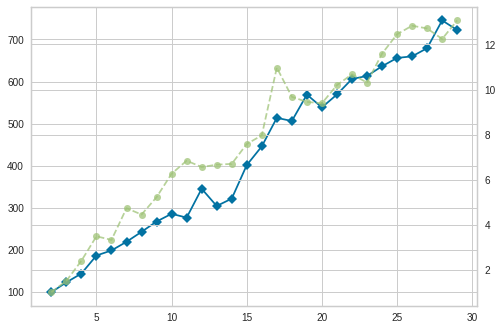

In [ ]:
# visualization with elbow curve

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

X=np.stack(df_train_fin["DocumentVector"], axis=0)
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,30))
visualizer.fit(X)

Hence, the idea of clustering is kept for completeness, but **not included into further model building**. 

## 7.2. Build NLP Neural Network (1)
The first NN is based on the feature **DocumentVector** and thus predicts the number of claps based on the textual data.

Remember, $\phi(1..k)$ denotes a mapping function of a regession neural network with $k$ input values and one output value. Here, the first MLPRegressor is trained on a feedforward neural network with

<center>$Claps \sim \phi_1(DocumentVector[1..200])$ </center>

where Claps is the regression target. Let $\psi_{1}$ be the predicted output of the first NN. $\psi_{1}$ is stored in the feature **NN1_output**.

In [ ]:
# import libraries

# for training
import sklearn
from sklearn import neural_network
from sklearn.model_selection import RandomizedSearchCV

# for assessment
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

### 7.2.1. NLP Model (1) : Prepare Randomized Grid Search

In [ ]:
# create grid with hidden layers for randomized CV
hiddenLayerGrid = []
for layers in range(1,10):
  for neurons in range(25, 201,25):
    # for position in len(neurons):
      hiddenLayerGrid.append((neurons,)*layers)

hiddenLayerGrid


[(25,),
 (50,),
 (75,),
 (100,),
 (125,),
 (150,),
 (175,),
 (200,),
 (25, 25),
 (50, 50),
 (75, 75),
 (100, 100),
 (125, 125),
 (150, 150),
 (175, 175),
 (200, 200),
 (25, 25, 25),
 (50, 50, 50),
 (75, 75, 75),
 (100, 100, 100),
 (125, 125, 125),
 (150, 150, 150),
 (175, 175, 175),
 (200, 200, 200),
 (25, 25, 25, 25),
 (50, 50, 50, 50),
 (75, 75, 75, 75),
 (100, 100, 100, 100),
 (125, 125, 125, 125),
 (150, 150, 150, 150),
 (175, 175, 175, 175),
 (200, 200, 200, 200),
 (25, 25, 25, 25, 25),
 (50, 50, 50, 50, 50),
 (75, 75, 75, 75, 75),
 (100, 100, 100, 100, 100),
 (125, 125, 125, 125, 125),
 (150, 150, 150, 150, 150),
 (175, 175, 175, 175, 175),
 (200, 200, 200, 200, 200),
 (25, 25, 25, 25, 25, 25),
 (50, 50, 50, 50, 50, 50),
 (75, 75, 75, 75, 75, 75),
 (100, 100, 100, 100, 100, 100),
 (125, 125, 125, 125, 125, 125),
 (150, 150, 150, 150, 150, 150),
 (175, 175, 175, 175, 175, 175),
 (200, 200, 200, 200, 200, 200),
 (25, 25, 25, 25, 25, 25, 25),
 (50, 50, 50, 50, 50, 50, 50),
 (75, 75,

### 7.2.2. NLP Model (1) : Randomized Grid Search

In [ ]:
# build NLP Regression NN: Claps ~ DocumentVector 

reg_ML_NLP = sklearn.neural_network.MLPRegressor(max_iter=1000, verbose = True)

param_list = {"hidden_layer_sizes": hiddenLayerGrid,
              "activation": ["logistic", "relu"], 
              "solver": ["adam"], 
              "alpha": [0.00005, 0.0001, 0.0005]}

X_NLP = [np.array(x) for x in df_train_fin.DocumentVector]

y_NLP = np.array(df_train_fin.Claps, dtype=float)
y_NLP = y_NLP.reshape((-1,1))

randCV_NLP = RandomizedSearchCV(reg_ML_NLP, param_list, scoring="neg_mean_squared_error", n_jobs=-1, n_iter=10 )
randCV_NLP.fit(X_NLP, y_NLP)


In [ ]:
randCV_NLP.best_params_

{'activation': 'relu',
 'alpha': 0.0001,
 'hidden_layer_sizes': (25, 25, 25, 25),
 'solver': 'adam'}

Based on the best parameters of the randomized parameter search, the following architecture of the first NN emerges:

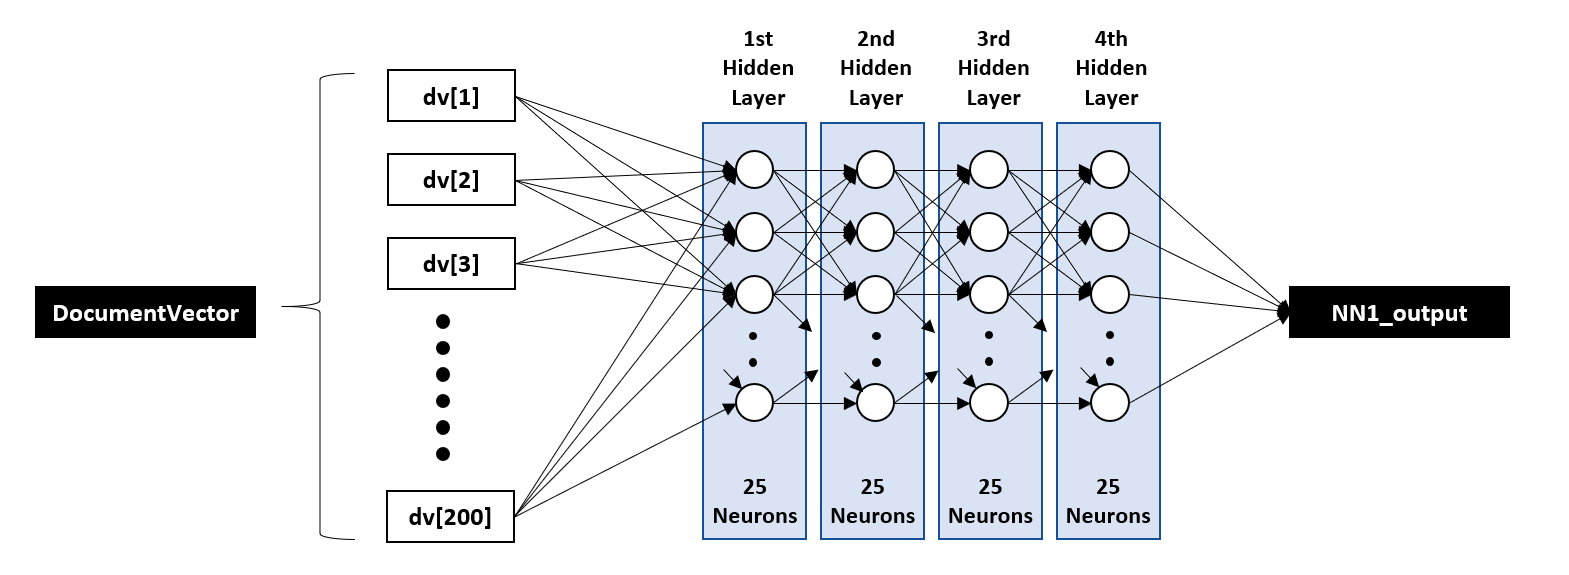

In [ ]:
# Image(filename='NN1.png')

In [ ]:
# backup randCV_NLP
with open('gdrive/My Drive/Adams Assignment/New Approach/randCV.pkl','wb') as path_name:
    pickle.dump(randCV_NLP, path_name)

In [ ]:
# re-load randCV_NLP
with open('gdrive/My Drive/Adams Assignment/New Approach/randCV.pkl','rb') as path_name:
    randCV_NLP = pickle.load(path_name)

### 7.2.3. NLP Model (1) : Assessment

In [ ]:
y_hat_NLP = randCV_NLP.predict(X_NLP)

In [ ]:
# accuracy on the training data

print("MSE: {}".format(mean_squared_error(y_NLP, y_hat_NLP)))
print("R^2: {}".format(r2_score(y_NLP, y_hat_NLP)))

MSE: 0.0744503037983564
R^2: 0.3696653357527896


### 7.2.4. NLP Model (1) : Create Output Feature

In [ ]:
# train data
X=[np.array(x) for x in df_train_fin.DocumentVector]
y_pred = randCV_NLP.predict(X)
df_train_fin["NN1_output"] = y_pred

In [ ]:
# val data
X=[np.array(x) for x in df_val_fin.DocumentVector]
y_pred = randCV_NLP.predict(X)
df_val_fin["NN1_output"] = y_pred

In [ ]:
# test data
X=[np.array(x) for x in df_test_fin.DocumentVector]
y_pred = randCV_NLP.predict(X)
df_test_fin["NN1_output"] = y_pred

In [ ]:
df_train_fin.head()

,Claps,Text,DaysPublication,AuthorFollowers,TitleWordCount,TextWordCount,DocumentVector,NN1_output
256583,1.000000,"[catch, near, future, commercial, ai, catch, n...",1.388788,0.440865,-0.104861,1.696101,"[-0.3093129392638314, -0.11153129572223189, 0....",0.463625
62151,0.509760,"[take, leap, data, science, take, leap, data, ...",1.477952,-0.626452,-0.415290,-0.907792,"[-0.7048988816493031, -0.22216329754262074, -0...",0.222917
270177,0.826588,"[compare, different, methods, achieve, sparse,...",-1.183215,1.412331,2.109287,0.804154,"[-0.1861217496249183, 0.660846884732171, -0.02...",0.807848
39471,0.000000,"[compliance, collaboration, key, data, project...",0.258091,2.021836,0.727353,-0.337829,"[-0.3596593484762964, -0.4861906697540034, -0....",0.279104
39747,0.630665,"[ai, accessibility, improve, user, access, ess...",0.147001,-0.665939,0.979435,0.403703,"[-0.4308867991698155, -0.18054565572336478, 0....",0.161272


## 7.3. Final Model
Using the output $\psi_{1}$ of the first NN and the remaining features, a second neural network is trained with

<center>$Claps \sim \phi_2(\psi_{1}, DaysPublication, AuthorFollowers, TitleWordCount, TextWordCount)$ </center>

where again Claps is the regression target and $\psi_{2}$ is the final prediction of the second model. This stacked model architecture has been chosen, in order to minimalize the regression training error $\varepsilon_{1}^{2}= (Claps - \psi_{1})^{2}$ of the first model.

### 7.3.1. Final Model (2) : Prepare Randomized Grid Search

In [ ]:
# create grid with hidden layers for randomized CV
hiddenLayerGrid2 = []
for layers in range(1,15):
  for neurons in range(3, 20, 1):
    # for position in len(neurons):
      hiddenLayerGrid2.append((neurons,)*layers)

hiddenLayerGrid2


[(3,),
 (4,),
 (5,),
 (6,),
 (7,),
 (8,),
 (9,),
 (10,),
 (11,),
 (12,),
 (13,),
 (14,),
 (15,),
 (16,),
 (17,),
 (18,),
 (19,),
 (3, 3),
 (4, 4),
 (5, 5),
 (6, 6),
 (7, 7),
 (8, 8),
 (9, 9),
 (10, 10),
 (11, 11),
 (12, 12),
 (13, 13),
 (14, 14),
 (15, 15),
 (16, 16),
 (17, 17),
 (18, 18),
 (19, 19),
 (3, 3, 3),
 (4, 4, 4),
 (5, 5, 5),
 (6, 6, 6),
 (7, 7, 7),
 (8, 8, 8),
 (9, 9, 9),
 (10, 10, 10),
 (11, 11, 11),
 (12, 12, 12),
 (13, 13, 13),
 (14, 14, 14),
 (15, 15, 15),
 (16, 16, 16),
 (17, 17, 17),
 (18, 18, 18),
 (19, 19, 19),
 (3, 3, 3, 3),
 (4, 4, 4, 4),
 (5, 5, 5, 5),
 (6, 6, 6, 6),
 (7, 7, 7, 7),
 (8, 8, 8, 8),
 (9, 9, 9, 9),
 (10, 10, 10, 10),
 (11, 11, 11, 11),
 (12, 12, 12, 12),
 (13, 13, 13, 13),
 (14, 14, 14, 14),
 (15, 15, 15, 15),
 (16, 16, 16, 16),
 (17, 17, 17, 17),
 (18, 18, 18, 18),
 (19, 19, 19, 19),
 (3, 3, 3, 3, 3),
 (4, 4, 4, 4, 4),
 (5, 5, 5, 5, 5),
 (6, 6, 6, 6, 6),
 (7, 7, 7, 7, 7),
 (8, 8, 8, 8, 8),
 (9, 9, 9, 9, 9),
 (10, 10, 10, 10, 10),
 (11, 11, 11, 11, 11

### 7.3.1. Final Model (2) : Randomized Grid Search

In [ ]:
reg_ML_fin = sklearn.neural_network.MLPRegressor(max_iter=1000, verbose = True)

param_list = {"hidden_layer_sizes": hiddenLayerGrid2,
              "activation": ["logistic", "relu"], 
              "solver": ["adam"], 
              "alpha": [0.00005, 0.0001, 0.0005]}

X_fin = df_train_fin[["DaysPublication", "AuthorFollowers", "TitleWordCount", "TextWordCount", "NN1_output"]]

y_fin = np.array(df_train_fin.Claps, dtype=float)
y_fin = y_fin.reshape((-1,1))

randCV_fin = RandomizedSearchCV(reg_ML_fin, param_list, scoring="neg_mean_squared_error", n_jobs=-1, n_iter=30 )
randCV_fin.fit(X_fin, y_fin)

In [ ]:
randCV_fin.best_params_

{'activation': 'relu',
 'alpha': 0.0005,
 'hidden_layer_sizes': (15, 15, 15, 15),
 'solver': 'adam'}

The following composite final model architecture with 4 hidden layers with 15 neurons each is chosen:

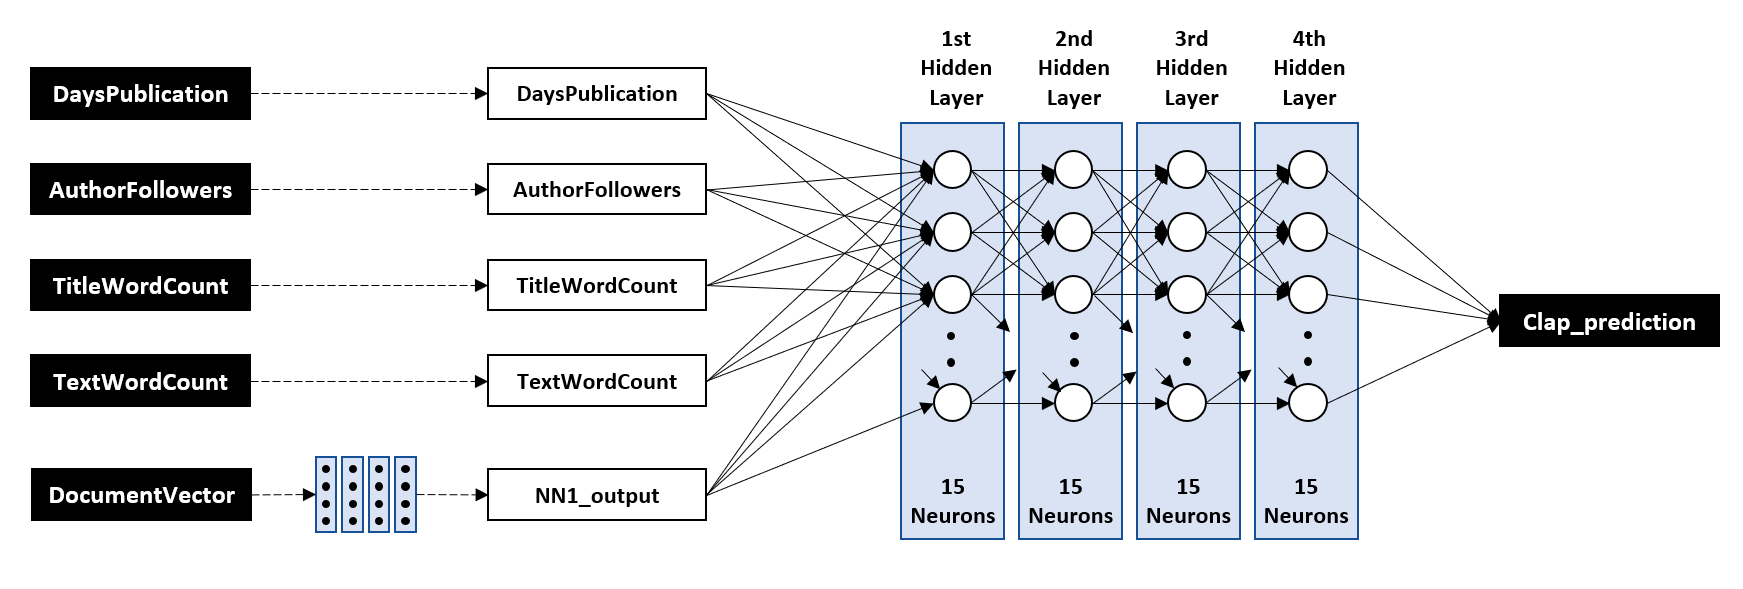

In [ ]:
# Image(filename='NN2.png')

In [ ]:
# backup randCV_fin
with open('gdrive/My Drive/Adams Assignment/New Approach/randCV_fin.pkl','wb') as path_name:
    pickle.dump(randCV_fin, path_name)

In [ ]:
# load randCV_fin
with open('gdrive/My Drive/Adams Assignment/New Approach/randCV_fin.pkl','rb') as path_name:
    randCV_fin = pickle.load(path_name)

### 7.3.2. Final Model (2) : Assessment on Training Data

In [ ]:
# reshape testing data
X_train = df_train_fin[["DaysPublication", "AuthorFollowers", "TitleWordCount", "TextWordCount", "NN1_output"]]

# predict
df_train_fin["predicted_Claps"] = randCV_fin.predict(X_train)

In [ ]:
# accuracy on the training data

print("MSE: {}".format(mean_squared_error(df_train_fin["Claps"], df_train_fin["predicted_Claps"])))
print("R^2: {}".format(r2_score(df_train_fin["Claps"], df_train_fin["predicted_Claps"])))

MSE: 0.061513515001722516
R^2: 0.4791948609062291


Based on the training data, this final model has improved the predictions compared to a plain NLP model (1), where $MSE_{(1)}= 0.0745$ and $R^2_{(1)}= 0.3697$. The composite model proves more efficient.

In [ ]:
# create a dataframe with retransformed Claps and predicted_claps
retransf_train = df_train_fin[["Claps", "predicted_Claps"]]
retransf_train.Claps = [re_Transformation_Claps(r) for r in retransf_train.Claps]
retransf_train.predicted_Claps = [re_Transformation_Claps(r) for r in retransf_train.predicted_Claps]

In [ ]:
retransf_train.head()

,Claps,predicted_Claps
256583,509.0,33.257059
62151,23.0,2.053096
270177,172.0,273.894357
39471,0.0,17.372487
39747,50.0,2.130746


In [ ]:
# accuracy on the training data after retransformation

print("MSE: {}".format(mean_squared_error(retransf_train["Claps"], retransf_train["predicted_Claps"])))
print("MAE: {}".format(mean_absolute_error(retransf_train["Claps"], retransf_train["predicted_Claps"])))
print("R^2: {}".format(r2_score(retransf_train["Claps"], retransf_train["predicted_Claps"])))

MSE: 13271.174987441234
MAE: 53.65373745319598
R^2: 0.23059118530595535


Though $R^2$ decreased, the predictions seem to be acceptable with a $MSE_{(2)}=13271.2$ and a $MAE_{(2)}=53.6$. That is, on average the predicion only deviates from the correct number of claps by about 53 claps. 

## 7.4. Final Model Assessment on Validation Data

These first assumptions on the model efficiency need to be validated with the validation data set.

In [ ]:
# reshape testing data
X_val = df_val_fin[["DaysPublication", "AuthorFollowers", "TitleWordCount", "TextWordCount", "NN1_output"]]

# predict
df_val_fin["predicted_Claps"] = randCV_fin.predict(X_val)

In [ ]:
df_val_fin.head()

,Claps,Text,DaysPublication,AuthorFollowers,TitleWordCount,TextWordCount,DocumentVector,NN1_output,predicted_Claps
55851,0.000000,"[improve, health_care, innovation, improve, he...",-0.426369,-0.101629,-0.748153,-1.582742,"[-0.14574049521357782, 0.24787024739048175, -0...",0.084036,0.080755
268386,0.659385,"[build, first, data_science, project, part, pr...",-1.141657,0.030690,0.727353,1.353981,"[0.15027108739248785, 0.455987625617021, 0.232...",0.687625,0.691085
239253,0.907222,"[miss, goal, germany, fate, world_cup, demonst...",-0.629422,-0.319474,1.679830,0.102023,"[-0.2748476533029247, 0.11142682805842724, 0.2...",0.452640,0.431644
170220,0.000000,"[collective, human, right, meet, ai, collectiv...",-0.911079,-0.874553,-0.415290,-0.252761,"[-0.22174196642817268, -0.09898683621904394, 0...",0.227247,0.182436
145780,0.176218,"[google_deepmind, develop, ai, predict, layout...",-0.577077,-0.071347,0.979435,-0.023187,"[-0.4164885507313187, 0.28916094243874424, -0....",0.616536,0.620490


In [ ]:
# create a dataframe with retransformed Claps and predicted_claps
retransf_val = df_val_fin[["Claps", "predicted_Claps"]]
retransf_val.Claps = [re_Transformation_Claps(r) for r in retransf_val.Claps]
retransf_val.predicted_Claps = [re_Transformation_Claps(r) for r in retransf_val.predicted_Claps]

In [ ]:
retransf_val.head(n=15)

,Claps,predicted_Claps
55851,0.0,0.654437
268386,60.0,73.329609
239253,285.0,13.747062
170220,0.0,2.118582
145780,2.0,46.865100
73414,1.0,19.987080
246602,57.0,2.503992
146837,119.0,24.727383
167396,321.0,122.177887
134870,59.0,140.958219


In [ ]:
# accuracy on the validation data after retransformation

print("MSE: {}".format(mean_squared_error(retransf_val["Claps"], retransf_val["predicted_Claps"])))
print("MAE: {}".format(mean_absolute_error(retransf_val["Claps"], retransf_val["predicted_Claps"])))
print("R^2: {}".format(r2_score(retransf_val["Claps"], retransf_val["predicted_Claps"])))

MSE: 14663.562792744362
MAE: 58.74575542077285
R^2: 0.13349038174048278


The model shows similar results when applied on the validation data set. Though $R^2_{val}$ decreased even further, the predictions seem to as accaptable as on the training data with a $MSE_{(2), val}=14663.6$ and a $MAE_{(2), val}=58.7$. That is, on average the predicion only deviates from the correct number of claps by about 58 claps. Since the models where trained with $MSE$ as loss function, I focus on this measure. 

## 7.5. Interpretation

The predictive power of the composite NN has been shown. In this section, a plain vanilla linear regression is run over the input features of model 2. This **surrogate model** gives insights into the black-box NN and helps to understand the dependencies of the features.

In [ ]:
# surrogate model - linear regression on: predicted_Claps ~ [DaysPublication, AuthorFollowers, TitleWordCount, TextWordCount, NN1_output]

from sklearn.linear_model import LinearRegression
X_lin = df_train_fin[["DaysPublication", "AuthorFollowers", "TitleWordCount", "TextWordCount", "NN1_output"]]
y_lin = np.array(df_train_fin.predicted_Claps, dtype=float)
y_lin = y_lin.reshape((-1,1))
lin_reg = LinearRegression().fit(X_lin, y_lin)
lin_reg.score(X_lin, y_lin)

0.952645317260666

In [ ]:
print(["DaysPublication", "AuthorFollowers", "TitleWordCount", "TextWordCount", "NN1_output"])
print(lin_reg.coef_)

['DaysPublication', 'AuthorFollowers', 'TitleWordCount', 'TextWordCount', 'NN1_output']
[[ 0.00583354  0.09949934 -0.00841753  0.02847117  0.84003992]]


The coefficients of the surrogate model demonstrate that the output of the first NLP regression model has the strongest impact on the final prediction. Hence, the article text and its related document vector have a lot of predictive power. 

The features **DaysPublication**, **AuthorFollowers** and **TextWordCount** have a weak positive effect on the number of claps per unit. The feature **TitleWordCount** shows a weak negative effect on the prediction of claps.

# 8. Final Predictions

# 8.1. Calculate Predictions for Test Data

In [ ]:
# reshape testing data
X_test = df_test_fin[["DaysPublication", "AuthorFollowers", "TitleWordCount", "TextWordCount", "NN1_output"]]

# predict
df_test_fin["predicted_Claps"] = randCV_fin.predict(X_test)

In [ ]:
df_test_fin.head()

,Index,Text,DaysPublication,AuthorFollowers,TitleWordCount,TextWordCount,DocumentVector
0,0,"[everyone, miss, mind_blow, feature, cryptocur...",3.182518,2.327131,0.463856,2.312811,"[-0.36383097389805963, -0.17429247831521033, 0..."
1,1,"[neo, versus, ethereum, neo, might, strongest,...",2.583197,2.533711,0.727353,2.388475,"[-0.16940387948896063, -0.575383800739601, -0...."
2,2,"[cryptocurrency, trade, bible, want, trade, cr...",3.227319,2.327131,-1.507654,-1.934529,"[-0.4807727076113224, -0.13983466809517459, 0...."
3,5,"[stablecoins, design, price, stable, cryptocur...",2.205768,2.659090,-0.748153,1.977172,"[-0.5314112407898075, -0.06769813359163174, 0...."
4,7,"[chaos, vs, order, cryptocurrency, dilemma, cr...",2.318804,2.244319,-0.748153,0.233396,"[-0.6283444019246075, -0.23537706750349655, 0...."


In [ ]:
min(df_test_fin["predicted_Claps"])
max(df_test_fin["predicted_Claps"])

1.387518383115597

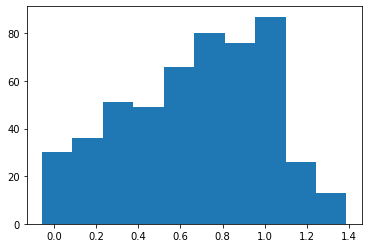

In [ ]:
_=plt.hist(df_test_fin["predicted_Claps"])

In [ ]:
# retransform the claps
df_test_fin["predicted_Claps_retransformed"] = [re_Transformation_Claps(r) for r in df_test_fin["predicted_Claps"]]

In [ ]:
df_test_fin.head()

,Index,Text,DaysPublication,AuthorFollowers,TitleWordCount,TextWordCount,DocumentVector,NN1_output,predicted_Claps,predicted_Claps_retransformed
0,0,"[everyone, miss, mind_blow, feature, cryptocur...",3.182518,2.327131,0.463856,2.312811,"[-0.36383097389805963, -0.17429247831521033, 0...",0.444075,0.968821,418.904561
1,1,"[neo, versus, ethereum, neo, might, strongest,...",2.583197,2.533711,0.727353,2.388475,"[-0.16940387948896063, -0.575383800739601, -0....",0.685264,1.115024,1043.731725
2,2,"[cryptocurrency, trade, bible, want, trade, cr...",3.227319,2.327131,-1.507654,-1.934529,"[-0.4807727076113224, -0.13983466809517459, 0....",0.497608,0.628303,49.254338
3,5,"[stablecoins, design, price, stable, cryptocur...",2.205768,2.659090,-0.748153,1.977172,"[-0.5314112407898075, -0.06769813359163174, 0....",0.372522,0.842331,189.840719
4,7,"[chaos, vs, order, cryptocurrency, dilemma, cr...",2.318804,2.244319,-0.748153,0.233396,"[-0.6283444019246075, -0.23537706750349655, 0....",0.283109,0.664498,61.975833


# 8.2. Save CSV File

In [ ]:
# create output DataFrame

df_submission = df_test_fin[["Index", "predicted_Claps_retransformed"]]
df_submission.columns= (["index", "Claps"])

In [ ]:
df_submission.head()

,index,Claps
0,0,418.904561
1,1,1043.731725
2,2,49.254338
3,5,189.840719
4,7,61.975833


In [ ]:
pth = "gdrive/My Drive/Adams Assignment/New Approach/Final_Submission.csv"
df_submission.to_csv(pth, sep=",", index=False)